<h2 align="right"> PH2103 Thermal Physics - Prof. Massimo Pica Ciamarra </h2> 


<h1 align="center"> One dimensional diffusion equation </h1> 


# Use of phyton
A jupyter script is a sequence of many cells. 

In our script, some cells contain text, as this one, other contain code.

To execute the code contained in a cell, just click on it and the press "shift+enter". The computation done in a cell depends on the previous computations. Execute the cells one after the other.

# One dimensional heat equation


## Introduction to the numerical technique
This script solves the one dimensional diffusion equation
$$ \frac{dT}{dt}= D \frac{d^2T}{dx^2} $$

We solve this equation numerically, discretizing both space and time.

We describe a one dimensional system of length $L$ as a sequence of $N = \frac{L}{dx}$ cells of length $dx$.
Cell $k$ correspond to the spatial location $k dx$.
In the code, we record the temperature of the different cells in a vector Temp[1], Temp[2], ..., Temp[N].


We evaluate the temperature profile, i.e., the value of the temperature on each of the cells, Temp[.], at discrete times $t = 0,dt,2d,\ldots$, where $dt$ is our 'integration timestep'. $dt$ is our temporal resolution.

To evolve the temperature profile, i.e. to get T[n,t+dt] at time $t+dt$ from $T[.,t]$ at time t, we use the diffusion equation.
Indeed, we can write $n = 2, \ldots N-1$:
$$T[n,t+dt] = = T[n,t] + \frac{dT[n,t]}{dt} \cdot dt = T[n,t] + D \frac{d^2T[n,t]}{dx^2} \cdot dt$$.

To use this equation to evaluate $T[n,t+dt]$, we have to estimate the second derivative. 
To this end, we resort to use the 2nd order central approximation (see https://en.wikipedia.org/wiki/Finite_difference)

$$\frac{d^2T[n,t]}{dx^2} = \frac{T[n+1,t]-2T[n,t]+T[n-1,t]}{dx^2}$$

Accordingly, given $T[n,t]$ we can evaluate $T[n,t+dt]$, and iterating the temperature at all times.
$$T[n,t+dt] = T[n,t] + D \frac{T[n+1,t]-2T[n,t]+T[n-1,t]}{dx^2} \cdot dt = T[n,t] + Dd2Txx[n,t] \cdot dt$$

Storing in memory the temperature profile at all times is too costly. We would need an array $T[i,t]$ with $i$ in the range $1$ to $N$ (the space) and $t$ in the range $0$ to $t_{tot}/dt$ where $t_{tot}$ is the total time we want to simulate. $t_{tot}/dt$ is generally very large, as we want to simulate long times and have a small temporal resolution.

To save memory, we do not store the value of the temperature at all times. 
Rather, $T[.]$ represent the temperature profile at the current time, we keep track of.
Henceforth, our algorithm consists is a simple loop:

<ol>
<li>Evaluate: $Dd2Tdxx[n] = \frac{T[n]-2T[n]+T[n-1]}{dx^2}$</li>
<li>Update the temperature: $T[n] = T[n] + Dd2Tdxx[n] \cdot dt$</li>
<li>Increment the time: $t_{elapsed} = t_{elapsed} + dt$</li>
</ol>

As a final note, this jupyter notebook contains two part. 

In the first one we consider D to be constant in space. This is a good approximation to model, for instance, how temperature varies within a given object. 

In the second one, we consider D to depend on space. In this case, we model in a simple way the cooling of coffee within a cup.

## Boundary conditions
Our loop governing the evolution of the temperature does not work for the first and the last cell, $n=1$ and $n=N$. Indeed, the calculation of $D2dTxx$ for the first cell asks for the value of $T[n-1] = T[0]$, which is not well defined. Similarly, for the last cell we need the value of $T[N+1]$. 

Accordingly, we need to fix a criterion for the evolution of the temperature at the boundaries, the boundary conditions. Here, for simplicity sake, we assume these cells to act as thermal baths, i.e. we are going to keep constant both $T[1]$ and $T[N]$.

## Initial condition
As initial condition, we need to specify the temperature on each of the $N$ cells. We theoretically free to do it as we wish. However, notice that the algorithm involves the computation of spatial derivatives. Accordingly, to have numerical instabilities it is convenient for $T[n]$ to smoothly depend on $n$.

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

## Model parameters - Spreading of a droplet/hot-spot
The physical system we will consider is a rod of length $L$. To discretize the system, we need to define the number of cells $N$, or equivalently $dx = L/N$, and the integration timestep, $dt$.


We also need to specify the material. The only material property entering into the diffusion equation is the diffusion coefficient, or thermal diffusivity. You can find typical values for different materials here: https://en.wikipedia.org/wiki/Thermal_diffusivity


Here we fix $D = 1$, $L = 1000$, and $dx = 1$, so that $N = 1000$. We also set $dt = 0.005$.
We also defined a variable to keep track of the elapsed time.

We also specify the total time of our simulations end_time, which we divide in ncurves segment of duration time_between_plots. To advance the time of this duration, we need to perform num_integration_loops integration loops.

In [6]:
"Model parameters"
D = 1
L = 1000

"Discretization"
dx = 1
N = int(L/dx)
dt = 0.1
#this is the vector storing the values of the temperature
Temp = np.empty(N)
#this is the vector storing the time derivative of the temperature
Dd2Txx = np.empty(N)

"Other variables"
#end simulation time
end_time = 5000
#time simulated so far
elapsed_time = 0
# we want to plot ncurves at regular time intervales
ncurves = 10
# time elapsed between plots
time_between_plots = end_time/ncurves
# number of integration loops between plot
num_integration_loops = int(time_between_plots/dt)

### Initialization
Before solving the equation, we need to specify the initial condition, i.e. the initial value of $T[n]$.
You can play with this part. Few examples are in the cell below. Uncomment the one you want to try, or write your own initial condition. 

Only warning: we are going to compute the second derivative of this object. If your initial condition has very large second derivatives, then in order to correctly solve the equation you need to use a very small $dt$.

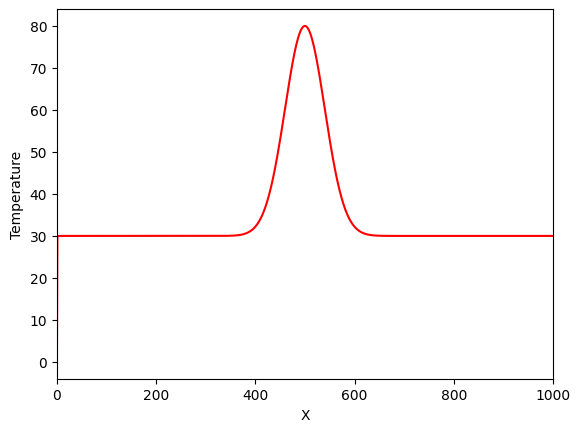

In [7]:
#ambient temperature (Celsius)
Tambient = 30
TMax=80

# use '#' to comment in an appropriate way

######################### intial condition is a Gaussian centered in L/2, with maximum temperature Tmax ##########
for i in range(1,N):
    Temp[i]= Tambient+(TMax-Tambient)*np.exp( -(i-N/2)**2/(2*40**2) )
#########################
    
######################### a central fraction of the system has a constant temperature, Tmax=80, the rest has ambient T
#for i in range(1,N):
#    Temp[int(N/2)-i]= Tambient
#fraction = 0.2
#T0 = 1
#for i in range(0, int(N*fraction*0.5)):
#    Temp[int(N/2)-i]= TMax
#    Temp[int(N/2)+i]= TMax
#############################

'Here we plot to intial condition, to check that everything is as expected'
plt.figure()
plt.xlim(0,1000)
plt.xlabel('X')
plt.ylabel('Temperature')

plt.plot(Temp,'r-')

### Evolution of the temperature profile

Temperature profile at time  500.0 1 10
Temperature profile at time  1000.0 2 10
Temperature profile at time  1500.0000000000002 3 10
Temperature profile at time  2000.0 4 10
Temperature profile at time  2500.0 5 10
Temperature profile at time  3000.0000000000005 6 10
Temperature profile at time  3500.0000000000005 7 10
Temperature profile at time  4000.0 8 10
Temperature profile at time  4500.0 9 10


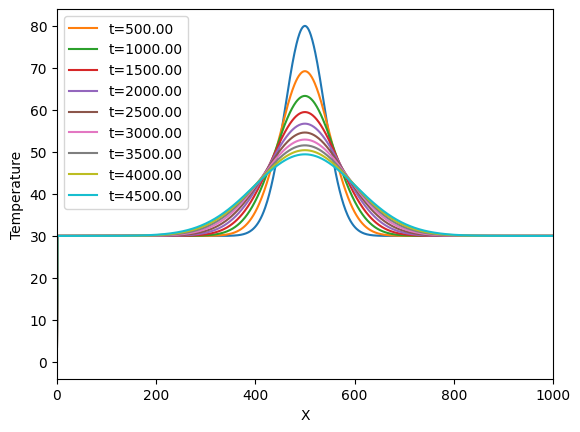

In [10]:
##################################### BE patient, the cell is running if you see [*] on the left

#this cell evolves the temperature profile and makes the plot
#the evolution requires some time

# we prepare a figure, i.e, the axis
plt.figure()
plt.xlim(0,1000)
plt.xlabel('X')
plt.ylabel('Temperature')
plt.plot(Temp) 
# reset the elapsed time; now, the temperature profile is the one we set above
elapsed_time = 0
for curve in range(1,ncurves):
    #we integrate time time between two consecuive plots
    #notice that the loops in n below exclude the first and the last cells, as the temperature there is fixed
    for step in range (1,num_integration_loops):
        #compute the derivative of the temperature
        for n in range(2,N-1):
            Dd2Txx[n] = D*(Temp[n+1]-2*Temp[n]+Temp[n-1])/(dx*dx)
        # update the temperature
        for n in range(2,N-1):
            Temp[n] = Temp[n]+Dd2Txx[n]*dt
        #advance time
        elapsed_time = elapsed_time+dt 
    print("Temperature profile at time ", curve*dt*num_integration_loops, curve, ncurves )
    plt.plot(Temp,label='t=%1.2f' %(curve*dt*num_integration_loops)) 
    plt.legend(loc='upper left')
    


## Model parameters - Cooling of a coffee cup
We now study the cooling of a one-dimensional coffe cup, to reproduce the experiment we have done in class. 

In this case we have three materials: 1) air outside of the cup, 2) the cup, 3) the how water inside. 
In our equation, this means that we have three different values of D. We use three different values for the thermal diffusivity of water, cup and air.

In [14]:
#in this cell we assigne the value of the thermal diffusivity along the space, D[].
Diffusivity = np.empty(N)
Dwater=5
Dcup=2
Dair=0.5
Tambient=0
DeltaT = 50

#everywhere is air
for i in range(1, 1000): 
    Diffusivity[i]=Dair
    Temp[i]=Tambient
#we overwrite in a central part, a there we have a cup and water. We first say we have in the center a cup
for i in range(500-200, 500+200):
    Diffusivity[i]=Dcup
    Temp[i]=DeltaT
#we overwrite a central part of the cup, to clarify that here there is actually water
for i in range(500-170, 500+170):
    Diffusivity[i]=Dwater
    Temp[i]=DeltaT

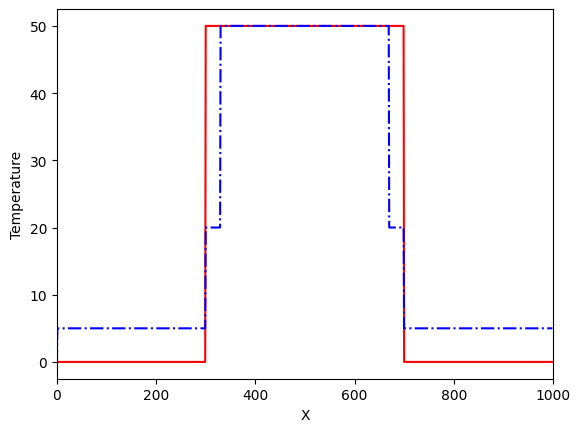

In [15]:
#Here we plot to intial condition, to check that everything is as expected
plt.figure()
plt.xlim(0,1000)
plt.xlabel('X')
plt.ylabel('Temperature')

plt.plot(Temp,'r-',label='temperature')
plt.plot(Diffusivity*10,'b-.',label='10 x diffusivity')

### Evolution of the temperature profile

Temperature profile at time  500.0 1 10
Temperature profile at time  1000.0 2 10
Temperature profile at time  1500.0000000000002 3 10
Temperature profile at time  2000.0 4 10
Temperature profile at time  2500.0 5 10
Temperature profile at time  3000.0000000000005 6 10
Temperature profile at time  3500.0000000000005 7 10
Temperature profile at time  4000.0 8 10
Temperature profile at time  4500.0 9 10


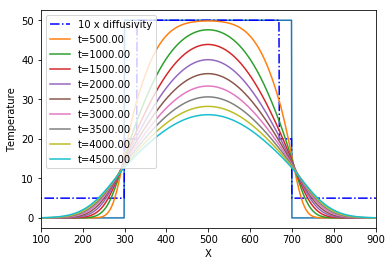

In [57]:
#the solution of the equation is as before, we just use a D dependent on space
plt.figure()
plt.xlim(0,1000)
plt.xlabel('X')
plt.ylabel('Temperature')
plt.xlim(100,900)
plt.plot(Temp) 
plt.plot(Diffusivity*10,'b-.',label='10 x diffusivity')
elapsed_time = 0
for curve in range(1,ncurves):
    #we integrate time time between two consecuive plots
    for step in range (1,num_integration_loops):
        #compute the derivative of the temperature
        for n in range(2,N-1):
            DTdt[n] = Diffusivity[n]*(Temp[n+1]-2*Temp[n]+Temp[n-1])/(dx*dx)
        # update the temperature
        for n in range(2,N-1):
            Temp[n] = Temp[n]+DTdt[n]*dt
        #advance time
        elapsed_time = elapsed_time+dt 
    print("Temperature profile at time ", curve*dt*num_integration_loops, curve, ncurves )
    plt.plot(Temp,label='t=%1.2f' %(curve*dt*num_integration_loops)) 
    plt.legend(loc='upper left')